## Import statements

- numpy, matplotlib are the usual libraries.

- fermi_libraries.run_module contains the data structure scripts used for compiling the raw data into easy-to-handle data.

- fermi_libraries.common_functions has generally useful functions with no specific goal.

- fermi_libraries.dictionary_search allows the filter capability of the Run.give_average_data() functions.

In [1]:
# uncomment the following line when you want to interact with the matplotlib plots
#%matplotlib widget

import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from fermi_libraries.run_module import Run, RunSets
from fermi_libraries.common_functions import (
    rebinning, simplify_data, avg_from_moments, stdev_from_moments,
    name_from_runs, set_recursion_limit, find_subdir, resolve_path)
from fermi_libraries.dictionary_search import search_symbols
import pathlib

There's a difference between looking for the current script location when running .py vs .ipynb files. This is the best way I could come up with to make things work for both.

In [2]:
try:
    CURRENT_SCRIPT_DIR = str(pathlib.Path(__file__).parent.resolve())+'/'
except NameError:  # this will happen in .ipynb files
    CURRENT_SCRIPT_DIR = os.path.abspath('')

### Function definitions (that you might change)

This extends our filtering capabilities from simple things (e.g. I0M>5) anything
you want. For example, if we want to filter by the averages of the TOF spectra,
we would define some other keyword function as "average_TOF", and write a rule
such as "average_TOF>4". Here is an extreme example below.

In [3]:
@set_recursion_limit(1)
def keyword_functions(keyword, aliasFunc, DictionaryObject):
    if False:
        pass

    elif keyword=='bunch_parity':
        bunches = DictionaryObject['bunches'][()]
        parity = bunches%2==0
        return parity

    elif keyword=='fel_wavelengths':
        padres_span = DictionaryObject['/photon_diagnostics/Spectrometer/WavelengthSpan'][()]
        padres_wavelength = DictionaryObject['/photon_diagnostics/Spectrometer/Wavelength'][()] + 0.0575
        padres_pixel2micron = DictionaryObject['/photon_diagnostics/Spectrometer/Pixel2micron'][()]
        padres_lambda = padres_wavelength + np.arange(-500, 500) * padres_pixel2micron * padres_span / 1000
        return padres_lambda
    
    elif keyword=='fel_wavelengths_avg':
        fel_lambda = keyword_functions('fel_wavelengths', aliasFunc, DictionaryObject)
        fel_spectrum = DictionaryObject['photon_diagnostics/Spectrometer/hor_spectrum'][()]
        average = avg_from_moments(fel_lambda, fel_spectrum, L=0.5)
        return average

    elif keyword=='fel_wavelengths_stdev':
        fel_lambda = keyword_functions('fel_wavelengths', aliasFunc, DictionaryObject)
        fel_spectrum = DictionaryObject['photon_diagnostics/Spectrometer/hor_spectrum'][()]
        stdev = stdev_from_moments(fel_lambda, fel_spectrum, L=0.5)
        return stdev

    elif keyword=='seed_wavelengths_avg':
        seed_spectrum = DictionaryObject['photon_source/SeedLaserSpectrum_FEL01/WaveMeta'][()]
        seed_lambda = DictionaryObject['photon_source/SeedLaserSpectrum_FEL01/LambdaMeta'][()]
        average = avg_from_moments(seed_lambda, seed_spectrum, L=0.5)
        return average

    elif keyword=='seed_wavelengths_stdev':
        seed_spectrum = DictionaryObject['photon_source/SeedLaserSpectrum_FEL01/WaveMeta'][()]
        seed_lambda = DictionaryObject['photon_source/SeedLaserSpectrum_FEL01/LambdaMeta'][()]
        stdev = stdev_from_moments(seed_lambda, seed_spectrum, L=0.5)
        return stdev

    elif keyword=='total_retardation':
        voltage_1 = DictionaryObject['endstation/MagneticBottle/voltage_ch1'][()]
        voltage_2 = DictionaryObject['endstation/MagneticBottle/voltage_ch2'][()]
        voltage_3 = DictionaryObject['endstation/MagneticBottle/voltage_ch3'][()]
        voltage_1_on = DictionaryObject['endstation/MagneticBottle/ch1_is_enabled'][()]
        voltage_2_on = DictionaryObject['endstation/MagneticBottle/ch2_is_enabled'][()]
        voltage_3_on = DictionaryObject['endstation/MagneticBottle/ch3_is_enabled'][()]
        retardation = voltage_1*voltage_1_on + voltage_2*voltage_2_on - voltage_3*voltage_3_on
        return retardation

    else:
        return DictionaryObject[aliasFunc(keyword)]

### Alias definitions

This lets us re-name the long HDF5 groupnames into more intuitive names e.g.
"digitizer/channel1" -> "ion_tof".
 

In [4]:
# Alternative names for the HDF5 groupnames
alias_dict = {
    'vmi' : 'vmi/andor',
    'ion_tof' : 'digitizer/channel1',
    'delay' : 'user_laser/delay_line/position',
    'slu' : 'user_laser/energy_meter/Energy2',
    }

---

# **Data selection**

This is the "options" part of the scripts, which we expect to change depending
on what we want. e.g. To look at different "Runs", we would change the
run_numbers variable.

Cacheing is provided as an option, to avoid recompiling raw data.

Maybe the "CURRENT_SCRIPT_DIR" is wrong, so you will have to adjust this
yourself; this is only an issue when we're all testing the scripts on our own
computers. Once we're all at the endstation, this will be fixed without any more
ambiguity.

In [5]:
# BEAMTIME_DIR =  '/net/online4ldm/store/20234049/results/Beamtime/'  # expected directory at FERMI
BEAMTIME_DIR =  f'{CURRENT_SCRIPT_DIR}/TestBeamtime/'
BEAMTIME_DIR = find_subdir('TestBeamtime', resolve_path(CURRENT_SCRIPT_DIR, '../..'))
DATA_DIR = f'{BEAMTIME_DIR}/Beamtime/'  # change from fictitious to the real raw data directory!
SAVE_DIR = f'{BEAMTIME_DIR}/results/evaluation/'#'/net/online4ldm/store/20234049/results/results' # ditto

SAVE_FILES = False

BACKGROUND = True  # Only set to False if you want to sum up everything
NAMEADD = 'test' # your name here
run_numbers = [1,]

MAKE_CACHE = True
LOAD_FROM_CACHE = False

CALIBRATION_RUN_NUMBER = 1

print(f'Run numbers: {run_numbers}')

Run numbers: [1]


Create RunCollection (main data structure), and print location of our save
directory. I don't expect this to ever change.

In [6]:
# This block loads all the relevent HDF5 filepaths into their respective Run.
RunCollection = {}  # We will put all the 'Runs' in thes dictionary
for run_id in (list(run_numbers) + [CALIBRATION_RUN_NUMBER,]):
    folderpath = os.path.join(DATA_DIR, f'Run_{run_id:03d}/rawdata')
    filepaths = [folderpath+'/'+filename for filename in os.listdir(folderpath)[::]]
    RunCollection[run_id] = Run(filepaths,
                                alias_dict=alias_dict, search_symbols=search_symbols,
                                keyword_functions=keyword_functions,
                                )  # create a Run object with its respective filepaths

# This is a single Run object
CalibrationRun = RunCollection[CALIBRATION_RUN_NUMBER]

# This creates a RunSet object
BasicRunSet = RunSets([])
for run in run_numbers:
    BasicRunSet.add([RunCollection[run]])
print(f'Data set contains {len(BasicRunSet.run_instances)} run(s).')

run_name = f'Runs {run_numbers[0]}-{run_numbers[-1]}'
run_string = name_from_runs(run_numbers)
prefix = os.path.join(SAVE_DIR, run_string)
outdir = (prefix + '_' + NAMEADD).rstrip('_')
print(f'Save directory: ...{outdir[30:]}')

Data set contains 1 run(s).
Save directory: ...cts/SolvatedElectronsBeamtime/examples/TestBeamtime//results/evaluation/run_0001_test


Create directory if non-existent (and if we are actually saving files).

In [7]:
if SAVE_FILES:
    if not os.path.exists(outdir):
        os.mkdir(outdir)

---

# Data compilation

Finally load some data! This is our bread-and-butter function to
load/filter/separate raw data, and compile into a more useful form.

**Everything stems from this function**. Play around with it!

The output for Runset.averageRunData and Runset.average_run_data_weights has the
axes shape (rule, condition, run, data):

- "rule" are the filtering rules
- "condition" is in the order (FEL:ON SLU:ON, FEL:OFF SLU:ON, FEL:ON SLU:OFF, FEL:OFF SLU:OFF)
- "run" are the individual Runs
- "data" is the average rundata/weights

If you ever get confused on the output_data you're getting, you can deduce which
axis stands for what by looking at the shape of the output_data:

> print(np.shape(output_data))

This is an example of using a "Run" object. This represents a single measurement and its replicates.

In [8]:
##%%time
single_run_vmi = CalibrationRun.average_run_data('vmi',back_sep=BACKGROUND,
                                    make_cache=MAKE_CACHE, use_cache=LOAD_FROM_CACHE)
print(f'shape of output data is: {np.shape(single_run_vmi)}')
print('data has axes (condition, rules, ...data...)')


shape of output data is: (4, 1, 900, 900)
data has axes (condition, rules, ...data...)


This is an example of using a "RunSet" object. This represents multiple measurements, and is what we will typically use all the time out of convenience.

In [9]:
##%%time
runset_vmi = BasicRunSet.average_run_data('vmi',back_sep=BACKGROUND,
                                    make_cache=MAKE_CACHE, use_cache=LOAD_FROM_CACHE)
print(f'shape of output data is: {np.shape(runset_vmi)}')
print('data has axes (condition, run, rules, ...data...)')

shape of output data is: (4, 1, 1, 900, 900)
data has axes (condition, run, rules, ...data...)


More often than not, we're looking at only a single Run, or aren't doing any
filtering rules. So we can get rid of the axes by using this simplify() function
as shown below.

In [10]:
fore_vmi, back_vmi, *_ = simplify_data(runset_vmi, single_rule=True, single_run=True)
print(f'shape of fore data is: {np.shape(fore_vmi)}')
print('data has axes (...data...)')

shape of fore data is: (900, 900)
data has axes (...data...)


Once you understand the what the average_run_data() and simplify_data()
functions do and give, everything else is just plotting and comparisons, and you
can do as you wish!

To see examples of plotting and comparisons, you can refer to the other scripts in the ./examples/ folder.

Here's an easy plot example below.

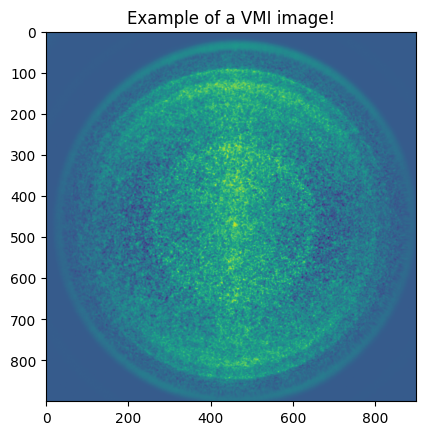

In [11]:
plt.imshow(fore_vmi - back_vmi)
plt.title('Example of a VMI image!')
plt.show()